# Training and Evaluation Module

## Libraries

In [1]:
import json
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from utils.logger import get_logger
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

## Logger Config

In [2]:
# Logger setup
logger = get_logger(__name__)

## CUDA setup

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Device Detected: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
logger.info(f"Using a {device} device")

[INFO] Device Detected: NVIDIA GeForce RTX 3070 Ti Laptop GPU
[INFO] Using a cuda device


## Load Label Map

In [4]:
with open("../data/processed/label_map.json", "r") as f:
    label_map = json.load(f)
    logger.info(f"Label map loaded with {len(label_map)} labels")

inv_label_map = {v: k for k, v in label_map.items()}
logger.info(f"Inverse label map created with {len(inv_label_map)} labels")

[INFO] Label map loaded with 5 labels
[INFO] Inverse label map created with 5 labels


## Dataset & Dataloaders

In [5]:
class FacialLandmarksDataset(Dataset):
    """
    Custom Dataset for loading facial landmarks data from a .npz file.
    This dataset expects the .npz file to contain 'features' and 'labels' arrays.
    """
    def __init__(self, path_npz):
        data = np.load(path_npz)
        self.features = torch.tensor(data["features"], dtype=torch.float32)
        self.labels = torch.tensor(data["labels"], dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [6]:
# Hyperparameters
batch_size = 64

# Load datasets made with dataset builder script
train_dataset = FacialLandmarksDataset("../data/processed/train.npz")
test_dataset = FacialLandmarksDataset("../data/processed/test.npz")

# Create DataLoaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## MLP Model for emotion classification

In [7]:
class EmotionClassifier(nn.Module):
    """
    A simple feedforward neural network for emotion classification based on facial landmarks.
    The network consists of two hidden layers with ReLU activations and dropout for regularization.

    The input dimension is set to 1434, which corresponds to the flattened facial landmarks,
    and the output dimension is set to 5, corresponding to the number of emotion classes.
    """
    def __init__(self, input_dim=1434, hidden_dim=512, num_classes=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [8]:
# Initialize the model, loss function, and optimizer
model = EmotionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Training Loop

In [ ]:
def train_model(model, loader, optimizer, criterion, epochs=20):
    """
    Train the model using the provided DataLoader, optimizer, and loss function.
    The training process runs for a specified number of epochs, updating the model weights
    based on the computed loss for each batch of data.

    Args:
        model (nn.Module): The neural network model to train.
        loader (DataLoader): DataLoader providing the training data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        criterion (nn.Module): Loss function to compute the loss.
        epochs (int): Number of epochs to train the model.
    
    Returns:
        None
    """
    # Set the model to training mode
    model.train()

    # Loop through the specified number of epochs
    for epoch in range(epochs):
        # Initialize the running loss for the epoch
        running_loss = 0.0
        # Configure tqdm for progress tracking
        loop = tqdm(loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)

        # Iterate over the DataLoader to get batches of data
        for features, labels in loop:
            # Move features and labels to the appropriate device (GPU/CPU)
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Update the tqdm loop description with the current loss
            loop.set_postfix(loss=loss.item())

        # Log the average loss for the epoch
        avg_loss = running_loss / len(loader)
        if (epoch == 0) or ((epoch + 1) % 5 == 0) or (epoch + 1 == epochs):
            logger.info(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}")

### Evaluation Loop

In [10]:
def evaluate_model(model, loader):
    """
    Evaluate the model on the provided DataLoader and print a classification report.
    This function computes the model's predictions on the dataset and compares them to the true labels,
    generating a classification report that includes precision, recall, and F1-score for each class.

    Args:
        model (nn.Module): The trained neural network model to evaluate.
        loader (DataLoader): DataLoader providing the evaluation data.

    Returns:
        None
    """
    # Set the model to evaluation mode
    model.eval()
    # Initialize lists to store predictions and true labels
    all_preds, all_labels = [], []
    logger.info("Evaluating model...")
    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Iterate over the DataLoader to get batches of data
        for features, labels in loader:
            # Move features and labels to the appropriate device (GPU/CPU)
            features = features.to(device)
            outputs = model(features)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    logger.info("Evaluation complete.\n")
    # print the classification report
    print(classification_report(all_labels, all_preds, target_names=label_map.values()))

    return all_preds, all_labels

## Visualizations

In [11]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=True):
    """
    Plot a confusion matrix using seaborn heatmap.
    This function computes the confusion matrix from the true labels and predicted labels,
    and visualizes it using a heatmap. The confusion matrix can be normalized to show 
    proportions instead of raw counts.

    Args:
        y_true (list): True labels of the dataset.
        y_pred (list): Predicted labels from the model.
        class_names (list): List of class names corresponding to the labels.
        normalize (bool): Whether to normalize the confusion matrix.

    Returns:
        None
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                cmap="Blues", xticklabels=class_names,
                yticklabels=class_names)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.tight_layout()
    plt.show()

## Training and Evaluation

In [12]:
train_model(model, train_loader, optimizer, criterion, epochs=100)

[INFO] Epoch 1/100, Avg Loss: 1.6033                                        
[INFO] Epoch 5/100, Avg Loss: 1.4128                                        
[INFO] Epoch 10/100, Avg Loss: 1.2054                                        
[INFO] Epoch 15/100, Avg Loss: 1.1397                                         
[INFO] Epoch 20/100, Avg Loss: 1.1042                                         
[INFO] Epoch 25/100, Avg Loss: 1.0619                                         
[INFO] Epoch 30/100, Avg Loss: 1.0534                                         
[INFO] Epoch 35/100, Avg Loss: 1.0239                                         
[INFO] Epoch 40/100, Avg Loss: 1.0065                                         
[INFO] Epoch 45/100, Avg Loss: 0.9891                                         
[INFO] Epoch 50/100, Avg Loss: 0.9794                                         
[INFO] Epoch 55/100, Avg Loss: 0.9677                                        
[INFO] Epoch 60/100, Avg Loss: 0.9725                     

In [13]:
predictions, labels = evaluate_model(model, test_loader)

[INFO] Evaluating model...
[INFO] Evaluation complete.



              precision    recall  f1-score   support

       anger       0.45      0.61      0.52       428
   happiness       0.93      0.73      0.82      1601
     neutral       0.73      0.76      0.75      2099
     sadness       0.30      0.33      0.31       592
    surprise       0.72      0.77      0.74       722

    accuracy                           0.69      5442
   macro avg       0.63      0.64      0.63      5442
weighted avg       0.72      0.69      0.70      5442



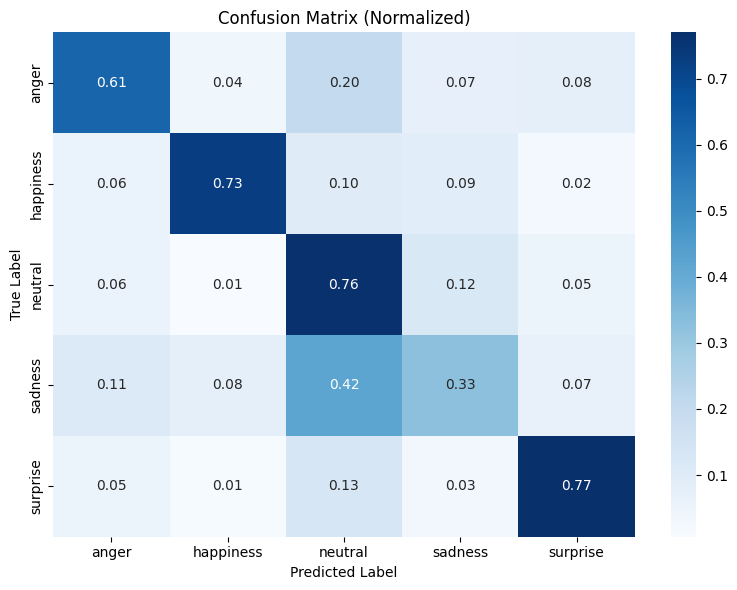

In [14]:
plot_confusion_matrix(labels, predictions, list(label_map.values()), normalize=True)

## Saving the model

In [15]:
torch.save(model.state_dict(), "models/pytorch/emotion_model.pth")
logger.info("Model saved to emotion_model.pth")

[INFO] Model saved to emotion_model.pth
